# Prototype
Martina Buck | 4.11.2020

## Goals
1.give a first impression of what the game could look like

2.demonstrate a possible game-mechanism

(All text and game mechanisms are just placeholders until something better comes along.)

**Magic commands**

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**External imports**

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import configparser
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

**Figure properties**

In [3]:
sns.set_context("poster")
sns.set(rc={'figure.figsize': (8, 5)})
sns.set_style("ticks")

**Directory structure**

In [4]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "plots")
project_dir

'/Users/felix/ETH/code/gecm'

**Append project directory to PYTHONPATH via sys (!)**

Source: https://stackoverflow.com/questions/39299838/how-do-i-import-module-in-jupyter-notebook-directory-into-notebooks-in-lower-dir

In [5]:
if project_dir not in sys.path:
    sys.path.append(project_dir)

**Only now we can import our own code from src**

In [6]:
from src.gecm import game, vis, io
from src.gecm.field import Map
from src.gecm.dicts import (
        original_lulc_mapping,
        lulc_remapping,
        simplified_lulc_mapping,
        simplified_lulc_mapping_colors
    )

**Set game parameters**

In [7]:
# size of playing field in pixels
n_pixels = 80

# complexity of playing field (only granularity = 1 works for now)
granularity = 1

**Other definitions and imports which are needed**

In [8]:
# colormap
simplified_lulc_cm = ListedColormap(
    [simplified_lulc_mapping_colors[x] for x in simplified_lulc_mapping_colors.keys()]
)

# path to raster data file (must be a geotiff)
fpath_map = os.path.join(
    data_processed, "NFI_rasterized_{}_{}.tif".format(n_pixels, n_pixels)
)

**Establish connection to Google Drive documents**

In [9]:
# init config file parser. methods: config.getboolean, config.getint, ... .
config = configparser.ConfigParser()
fpath_cf = os.path.join(project_dir, 'config.ini')
config.read(fpath_cf)

['/Users/felix/ETH/code/gecm/config.ini']

**Show configuration file sections**

In [10]:
io.config_describe(config)


--- default ---
credentials: 'google_api_credentials.json'
scopes: https://www.googleapis.com/auth/spreadsheets.readonly

--- gdrive_spreadsheet_ids ---
spreadsheet_id_farmers: 1kEEcKdP__1XbYKe5-nVlxzAD_P5-EQx-23IAw9SXOoc
spreadsheet_id_foresters: 1ir8WkfKpyEGkamASbd0pf9IDAE74M4Q1fsHYl4r9F34
spreadsheet_id_tourism: 1EA_mCM9Pp_URb_JavM-mMIqixTvZewSkGC2b-wDa1ns
spreadsheet_id_model: 1CVdDndGD1S8ab3D1KlXYcBcnjK8sBPl68Eth0KMgaEQ

--- gdrive_sheet_names ---
sheet_names_farmers: Farmer_1, Farmer_2
sheet_names_foresters: Forester_1, Forester_2
sheet_names_tourism: SSDA
sheet_names_parameters: model_parameters
sheet_names_calculations: model_calculations


**Parse management decisions** --> As a first example, read the farmer's decisions.

Parameter settings

In [11]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = [config.get(section="default", option="scopes")]

# <Your spreadsheet ID>
SPREADSHEET_ID = config.get(section="gdrive_spreadsheet_ids", option="spreadsheet_id_farmers")

# <Your worksheet names>
SHEETS_STRING = config.get(section="gdrive_sheet_names", option="sheet_names_farmers")
SHEETS = io.parse_list(config_string=SHEETS_STRING)

# API credentials
credentials_fpath = os.path.join(project_dir, 'google_api_credentials.json')

**Define the playing field**

load map

In [12]:
playing_field = Map(
    fpath=fpath_map,
    original_lulc_mapping=original_lulc_mapping,
    simplified_lulc_mapping=simplified_lulc_mapping,
    lulc_remapping=lulc_remapping,
    cmap=simplified_lulc_cm
)

**initialise playing field (crucial, else nothing works!)**

In [13]:
playing_field.initialise(granularity=1)

**sanity check on current round**

In [14]:
assert playing_field.current_round == 1

# Fancy game name

## First game instructions
 
- Landscape is an ever changing thing. But those changes don't always happen without conflicts. 
- In the following game, you will be part of a group of stakeholders. 
- You can take the role of being foresters, farmers or tourism association representatives.
- To start a new game and distribute all roles, fill in the numbers of players (3 to 6). --> only "number_of_players = 6" works so far!

In [15]:
number_of_players = 6
game.roles(number_of_players)

There are 6 roles for each player, Farmer 1 and 2, Forester 1 and 2 and Tourism association (SSDA) representatives 1 and 2. Please distribute each role among yourselves


- To play the game, every player fills out his decisions on what to do with his land on the google sheet for his role (maybe we could put here a link but then everyone has acces to everyones decisions...). A map of the area changes based on your decisions.

In [16]:
df_mgtmt_decisions = io.parse_mgmt_decisions(
    spreadsheet_id=SPREADSHEET_ID, 
    sheets=SHEETS, 
    credentials_fpath=credentials_fpath, 
    scopes=SCOPES, 
    unstack_data=True
)

Farmer_1
Farmer_2


<AxesSubplot:title={'center':'Round 0'}, xlabel='round', ylabel='Management decisions (%)'>

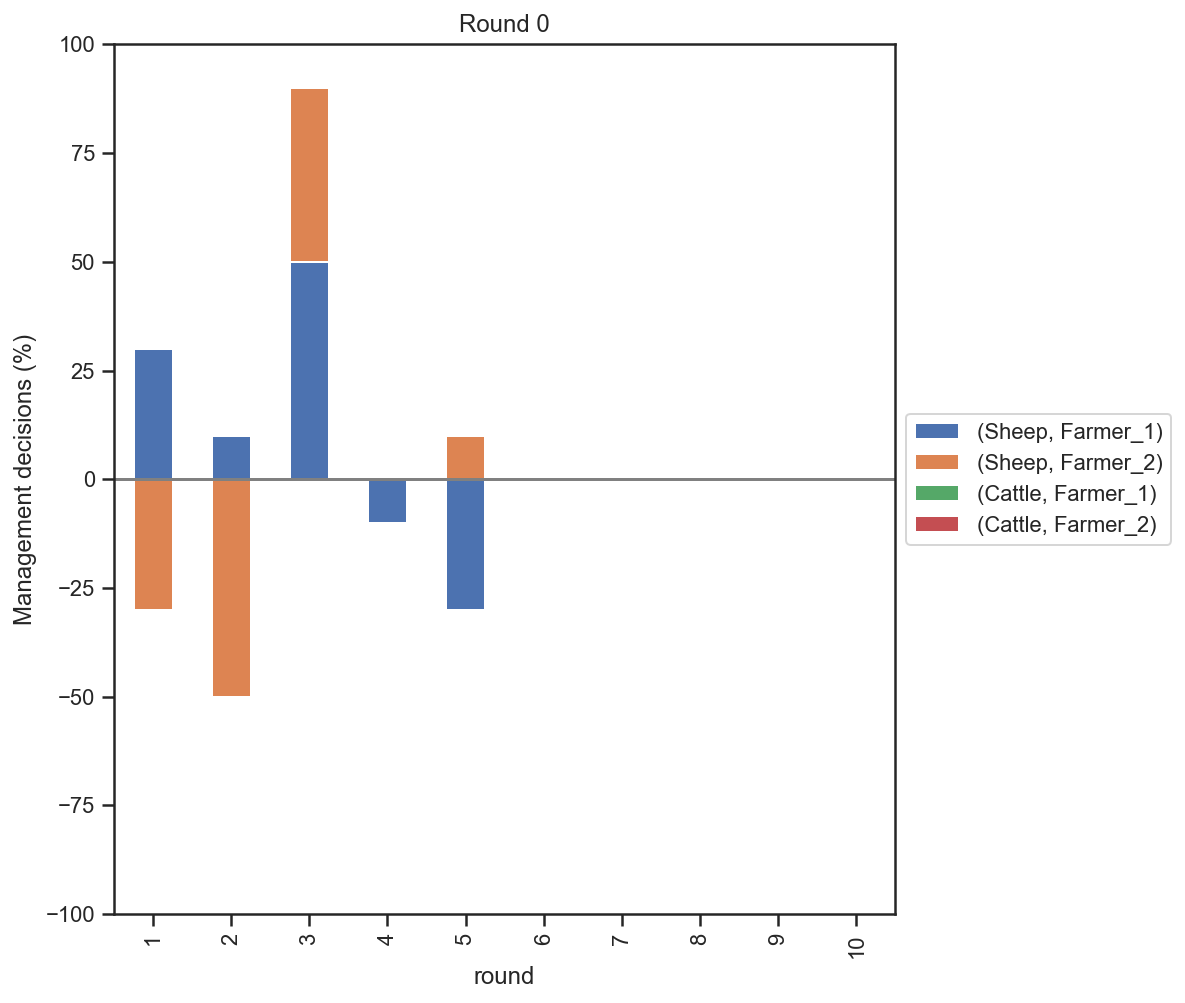

In [23]:
%reload_ext autoreload
# select parameter subset
column_subset = ["Sheep", "Cattle"]

# visualise
vis.show_mgmt_decisions(df_mgtmt_decisions, current_round=0, cols=column_subset, box_width_scaling=0.7)

## Starting point

Now have a look at playing field.

You find yourselves in Scottland in the area of Galloway and Southern Ayrshire Biosphere. The government decided that more forest area in Scottland is needed to help combate climate change. At the same time, the people of Scottland need steady jobs with a decent pay. You find yourself either managing Farmland, Forest or tourism industry (SSDA) representative.

As a farmer, you can make money by selling agricultural products. As a forester, you can make money by selling timber. As a tourism industry (SSDA) representative, you represent the interests of the local tourism industry, which primarily consist of micro-businesses (less than 10 employees).

<AxesSubplot:xlabel='Percent of total area (%)'>

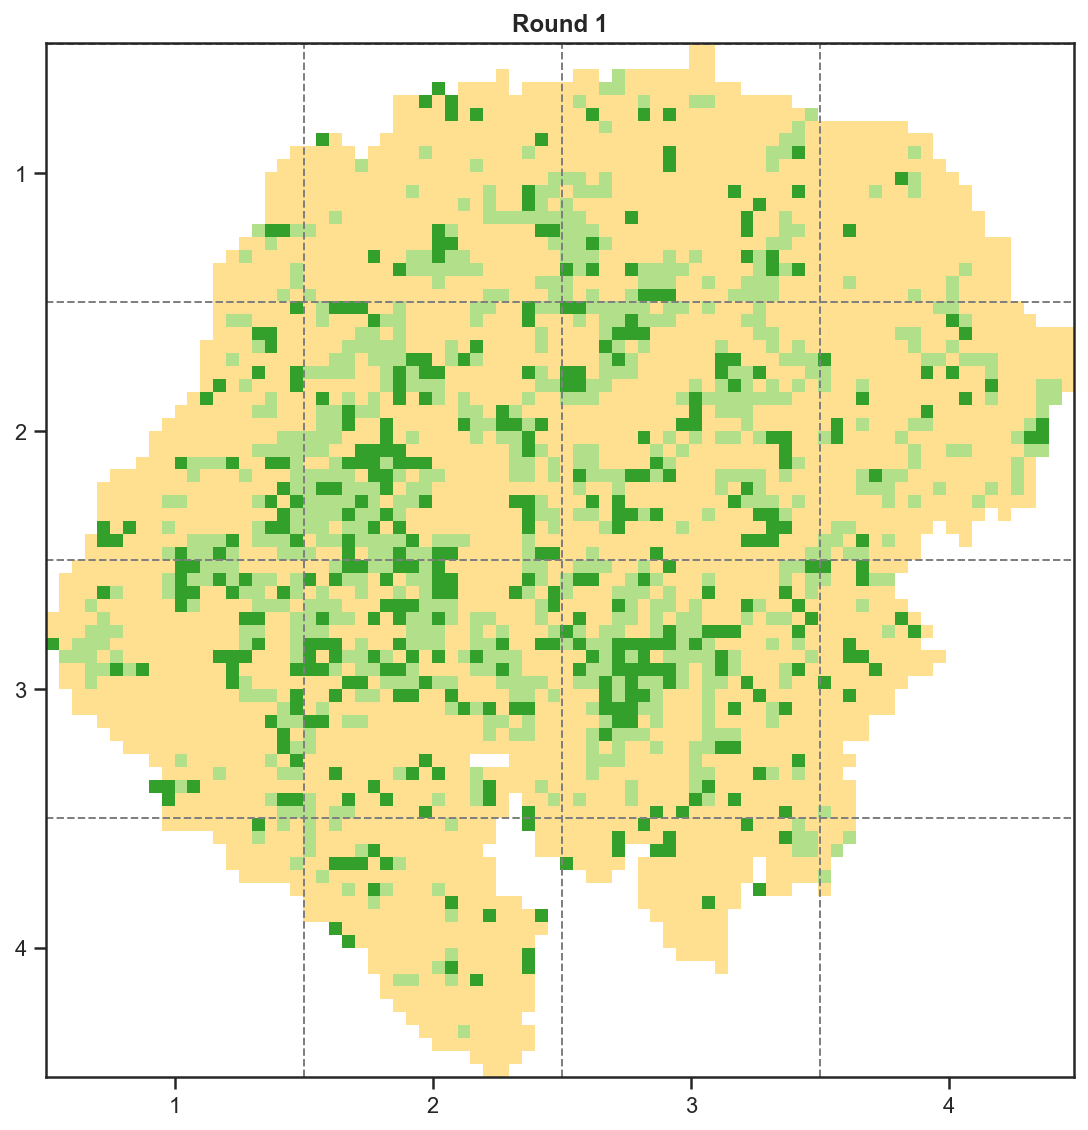

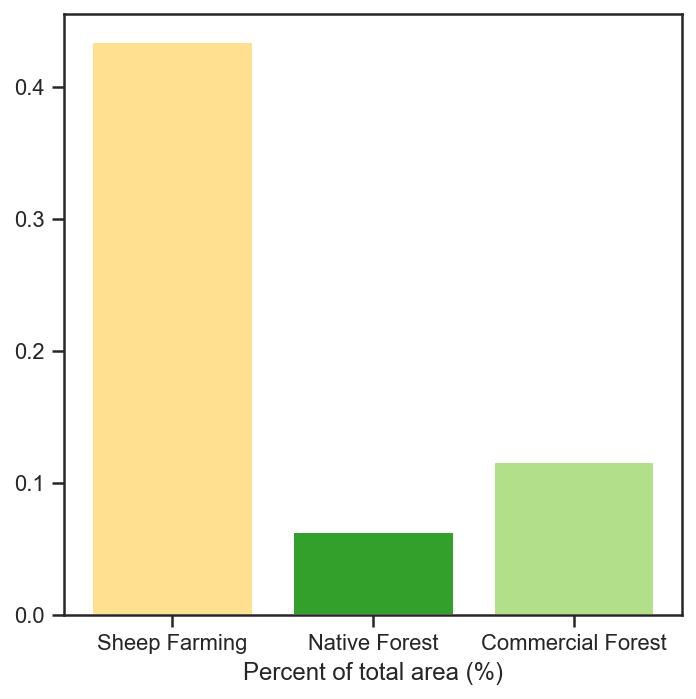

In [18]:
%reload_ext autoreload
playing_field.show(figure_size=(8,8))
playing_field.show_bar(figure_size=(5,5))

## Round 1

Please wait a moment while we are accessing your management decisions ...

In [27]:
df_mgtmt_decisions = io.parse_mgmt_decisions(
    spreadsheet_id=SPREADSHEET_ID, 
    sheets=SHEETS, 
    credentials_fpath=credentials_fpath, 
    scopes=SCOPES, 
    unstack_data=True
)

Farmer_1
Farmer_2


Let's have a look at the decisions of all stakeholders --> **TODO: probably remove this, especially in first round**

<AxesSubplot:title={'center':'Round 1'}, xlabel='round', ylabel='Management decisions (%)'>

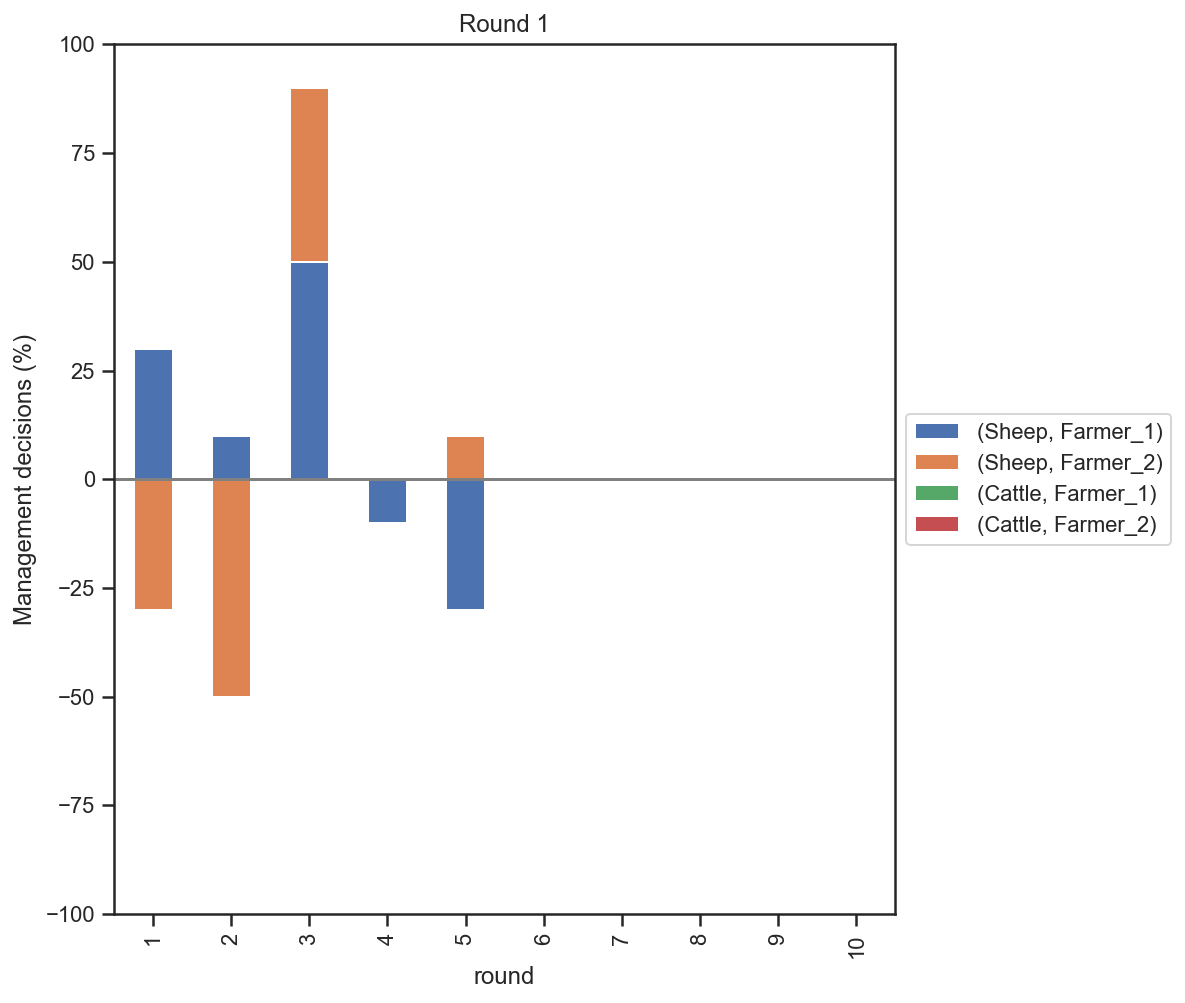

In [28]:
%reload_ext autoreload
# select parameter subset
column_subset = ["Sheep", "Cattle"]

# visualise
vis.show_mgmt_decisions(df_mgtmt_decisions, current_round = playing_field.current_round, cols=column_subset, box_width_scaling=0.7)

Done! Please wait a final moment while we are updating the playing field based on your management decisions.

In [29]:
# TODO: update map based on conceptual model

Let's evaluate the impact of your first management decisions on the landscape ...

In [20]:
# TODO: display updated map and bar-charts with LULC changes

... and on regional GDP & employment:

In [21]:
# TODO: display the state of GDP and employment

## Round 2

## Round 3